In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

In [2]:
# Set dataset paths
dataset_path = "/kaggle/input/140k-real-and-fake-faces"  # Update this to your dataset path
train_dir = os.path.join(dataset_path, "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train")
val_dir = os.path.join(dataset_path, "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid")
test_dir = os.path.join(dataset_path, "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test")


In [3]:
# Data preprocessing with optimized augmentation
data_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = data_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=64, class_mode='binary')
val_data = data_gen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=64, class_mode='binary')
test_data = ImageDataGenerator(rescale=1.0/255).flow_from_directory(test_dir, target_size=(224, 224), batch_size=64, class_mode='binary', shuffle=False)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [5]:
# Build model inside strategy scope

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
        layer.trainable = True  # Fine-tune all layers

        x = GlobalAveragePooling2D()(base_model.output)
        x = BatchNormalization()(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.4)(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.3)(x)
        output = Dense(1, activation='sigmoid', dtype='float32')(x)
        model = Model(inputs=base_model.input, outputs=output)

    # Learning rate scheduling
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9)
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])

# Train model
epochs = 10
history = model.fit(train_data, validation_data=val_data, epochs=epochs)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2386s 1s/step - accuracy: 0.8912 - loss: 0.2575 - val_accuracy: 0.9700 - val_loss: 0.0736
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1586s 1s/step - accuracy: 0.9793 - loss: 0.0566 - val_accuracy: 0.8618 - val_loss: 0.3946
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1591s 1s/step - accuracy: 0.9866 - loss: 0.0377 - val_accuracy: 0.9747 - val_loss: 0.0730
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1584s 1s/step - accuracy: 0.9893 - loss: 0.0307 - val_accuracy: 0.9434 - val_loss: 0.1596
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1569s 1000ms/step - accuracy: 0.9923 - loss: 0.0216 - val_accuracy: 0.9938 - val_loss: 0.0179
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1572s 1s/step - accuracy: 0.9939 - loss: 0.0166 - val_accuracy: 0.9197 - val_loss: 0.2938
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1598s 1s/step - accuracy: 0.9963 - loss: 0.0106 - val_accuracy: 0.9279 - val_loss: 0.1989
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1590s 1s/step - accuracy: 0.9973 - loss: 

In [6]:
# Evaluate model
loss, accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {accuracy:.2f}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 187s 598ms/step - accuracy: 0.9561 - loss: 0.1479
Test Accuracy: 0.97


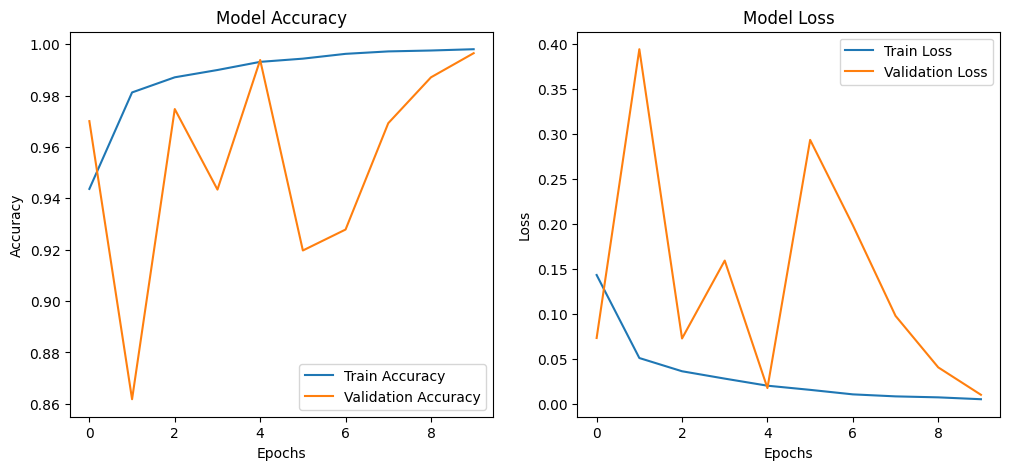

In [8]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()



In [9]:
# Generate classification report
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))

313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 197ms/step
              precision    recall  f1-score   support

        fake       1.00      0.95      0.97     10000
        real       0.95      1.00      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.97      0.97     20000



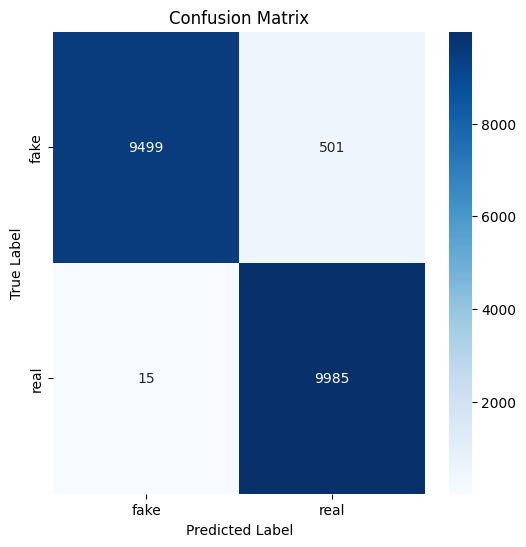

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


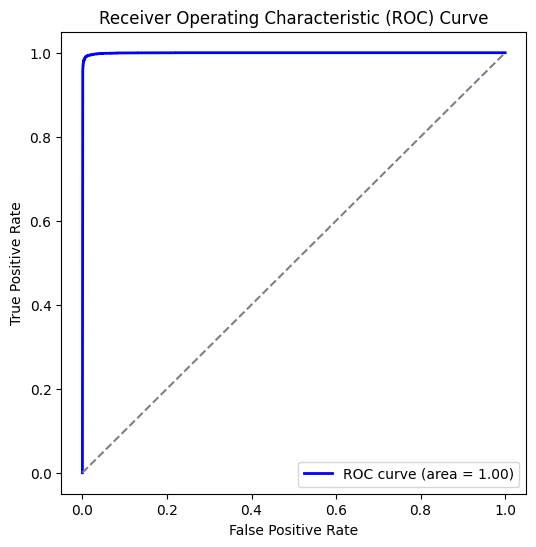

In [11]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

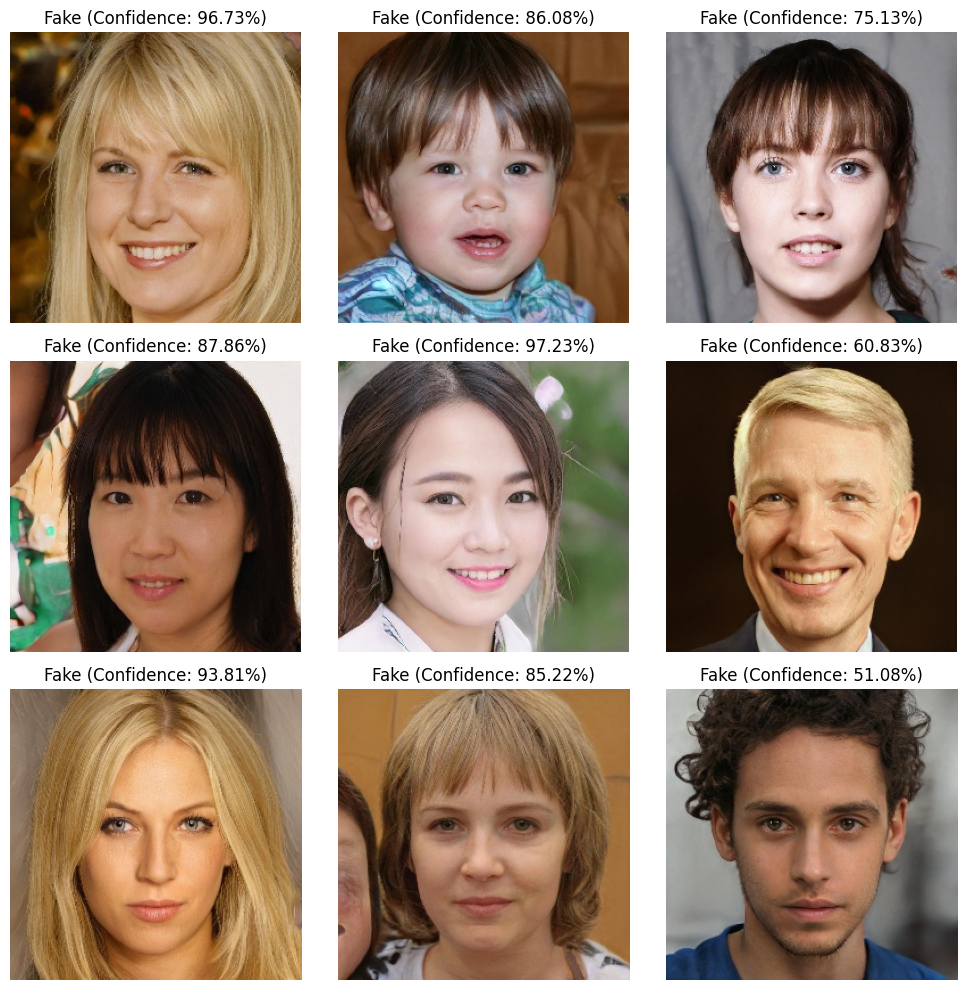

In [12]:
# Display predicted fake images
fake_indices = np.where(y_pred == 1)[0]

plt.figure(figsize=(10, 10))
for i, idx in enumerate(fake_indices[:9]):  # Show first 9 fake images
    img_path = os.path.join(test_dir, test_data.filenames[idx])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f"Fake (Confidence: {y_pred_probs[idx][0] * 100:.2f}%)")
    plt.axis('off')
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


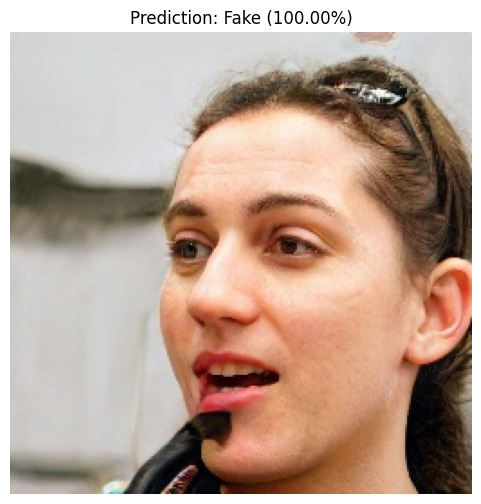

Predicted: Fake, Confidence: 100.00%


In [13]:
def predict_image(image_path, model):
    from tensorflow.keras.preprocessing import image
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims for batch size

    # Get prediction
    prediction = model.predict(img_array)[0][0]

    # Swapping labels to correct the misclassification
    predicted_label = "Real" if prediction > 0.5 else "Fake"
    confidence = prediction * 100 if prediction > 0.5 else (1 - prediction) * 100

    # Display image with prediction
    img_cv = cv2.imread(image_path)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_cv)
    plt.title(f"Prediction: {predicted_label} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    return predicted_label, confidence

# Example usage
image_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00F8LKY6JC.jpg"  # Change this to the image you want to test
predicted_label, confidence = predict_image(image_path, model)
print(f"Predicted: {predicted_label}, Confidence: {confidence:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


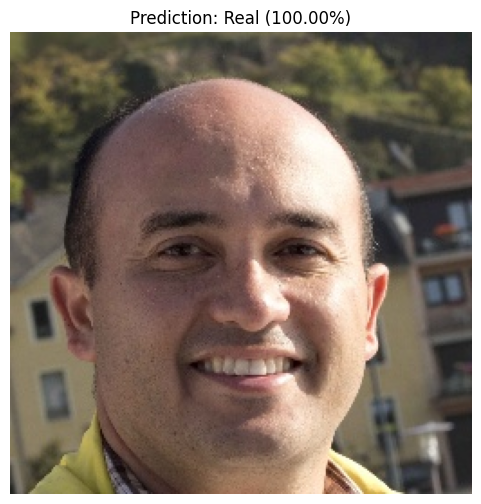

Predicted: Real, Confidence: 100.00%


In [14]:
def predict_image(image_path, model):
    from tensorflow.keras.preprocessing import image
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims for batch size

    # Get prediction
    prediction = model.predict(img_array)[0][0]

    # Swapping labels to correct the misclassification
    predicted_label = "Real" if prediction > 0.5 else "Fake"
    confidence = prediction * 100 if prediction > 0.5 else (1 - prediction) * 100

    # Display image with prediction
    img_cv = cv2.imread(image_path)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_cv)
    plt.title(f"Prediction: {predicted_label} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    return predicted_label, confidence

# Example usage
image_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00045.jpg"  # Change this to the image you want to test
predicted_label, confidence = predict_image(image_path, model)
print(f"Predicted: {predicted_label}, Confidence: {confidence:.2f}%")
